In [ ]:
!pip install transformers

In [ ]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/intents.json'

intents = load_json_file(filename)

In [ ]:
df = pd.DataFrame(columns=['Pattern', 'Tag'])
df

,Pattern,Tag


In [ ]:
def extract_json_info(json_file):
    data = [(pattern, intent['tag']) for intent in json_file['intents'] for pattern in intent['patterns']]
    return pd.DataFrame(data, columns=['Pattern', 'Tag'])

df = extract_json_info(intents)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [ ]:
print(f"This Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

This Dataset has 405 rows and 2 columns


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


In [ ]:
unique_values = df.value_counts()
unique_values

Pattern                    Tag        
how much is the fees       fees           2
floors in college          floors         2
college timing             hours          2
syllabus                   syllabus       2
exam dates                 sem            2
                                         ..
courses offered            course         1
courses available at UNI?  course         1
contact info               number         1
computer hod               computerhod    1
your name                  name           1
Length: 398, dtype: int64

In [ ]:
unique_classes = len(df['Tag'].unique())
print("Number of Classes is " ,unique_classes)

Number of Classes is  38


In [ ]:
df.isnull().sum()

Pattern    0
Tag        0
dtype: int64

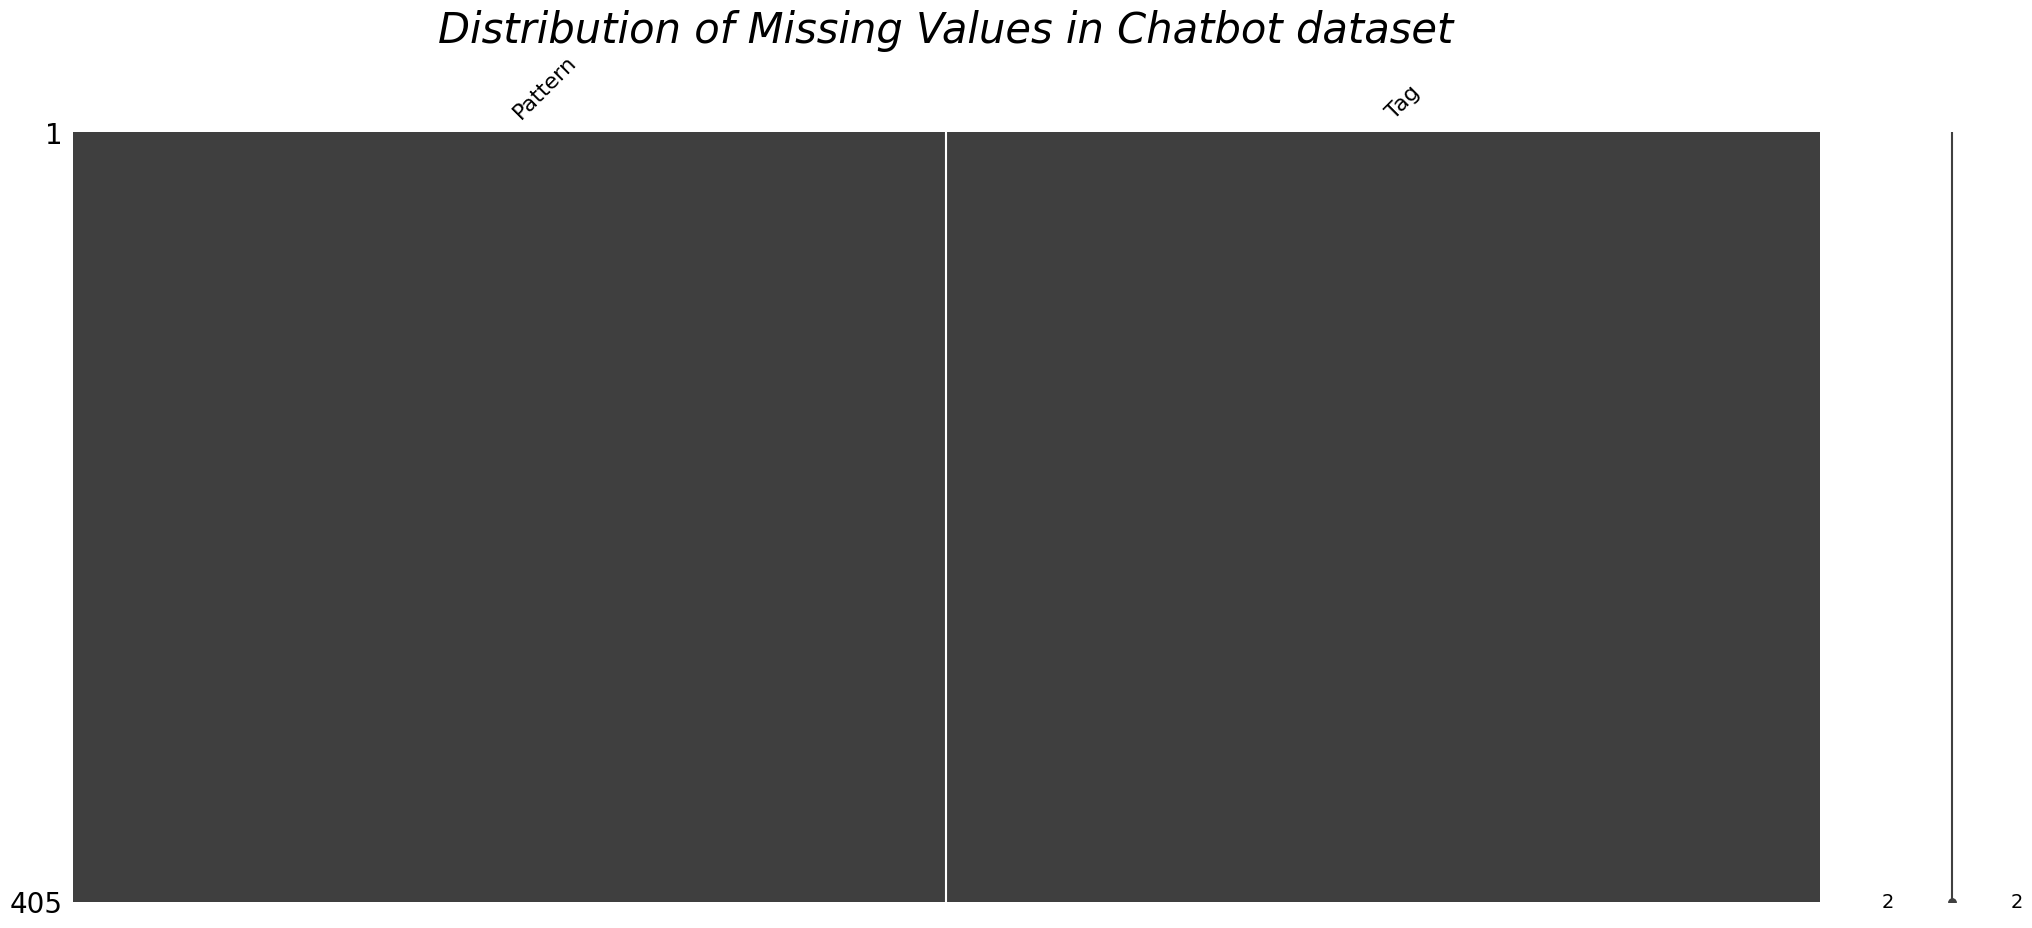

In [ ]:
msno.matrix(df)
plt.title(f'Distribution of Missing Values in Chatbot dataset', fontsize=30, fontstyle='oblique')
plt.show()

In [ ]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
        ha='center', va='bottom') # set the alignment of the text

    plt.show()

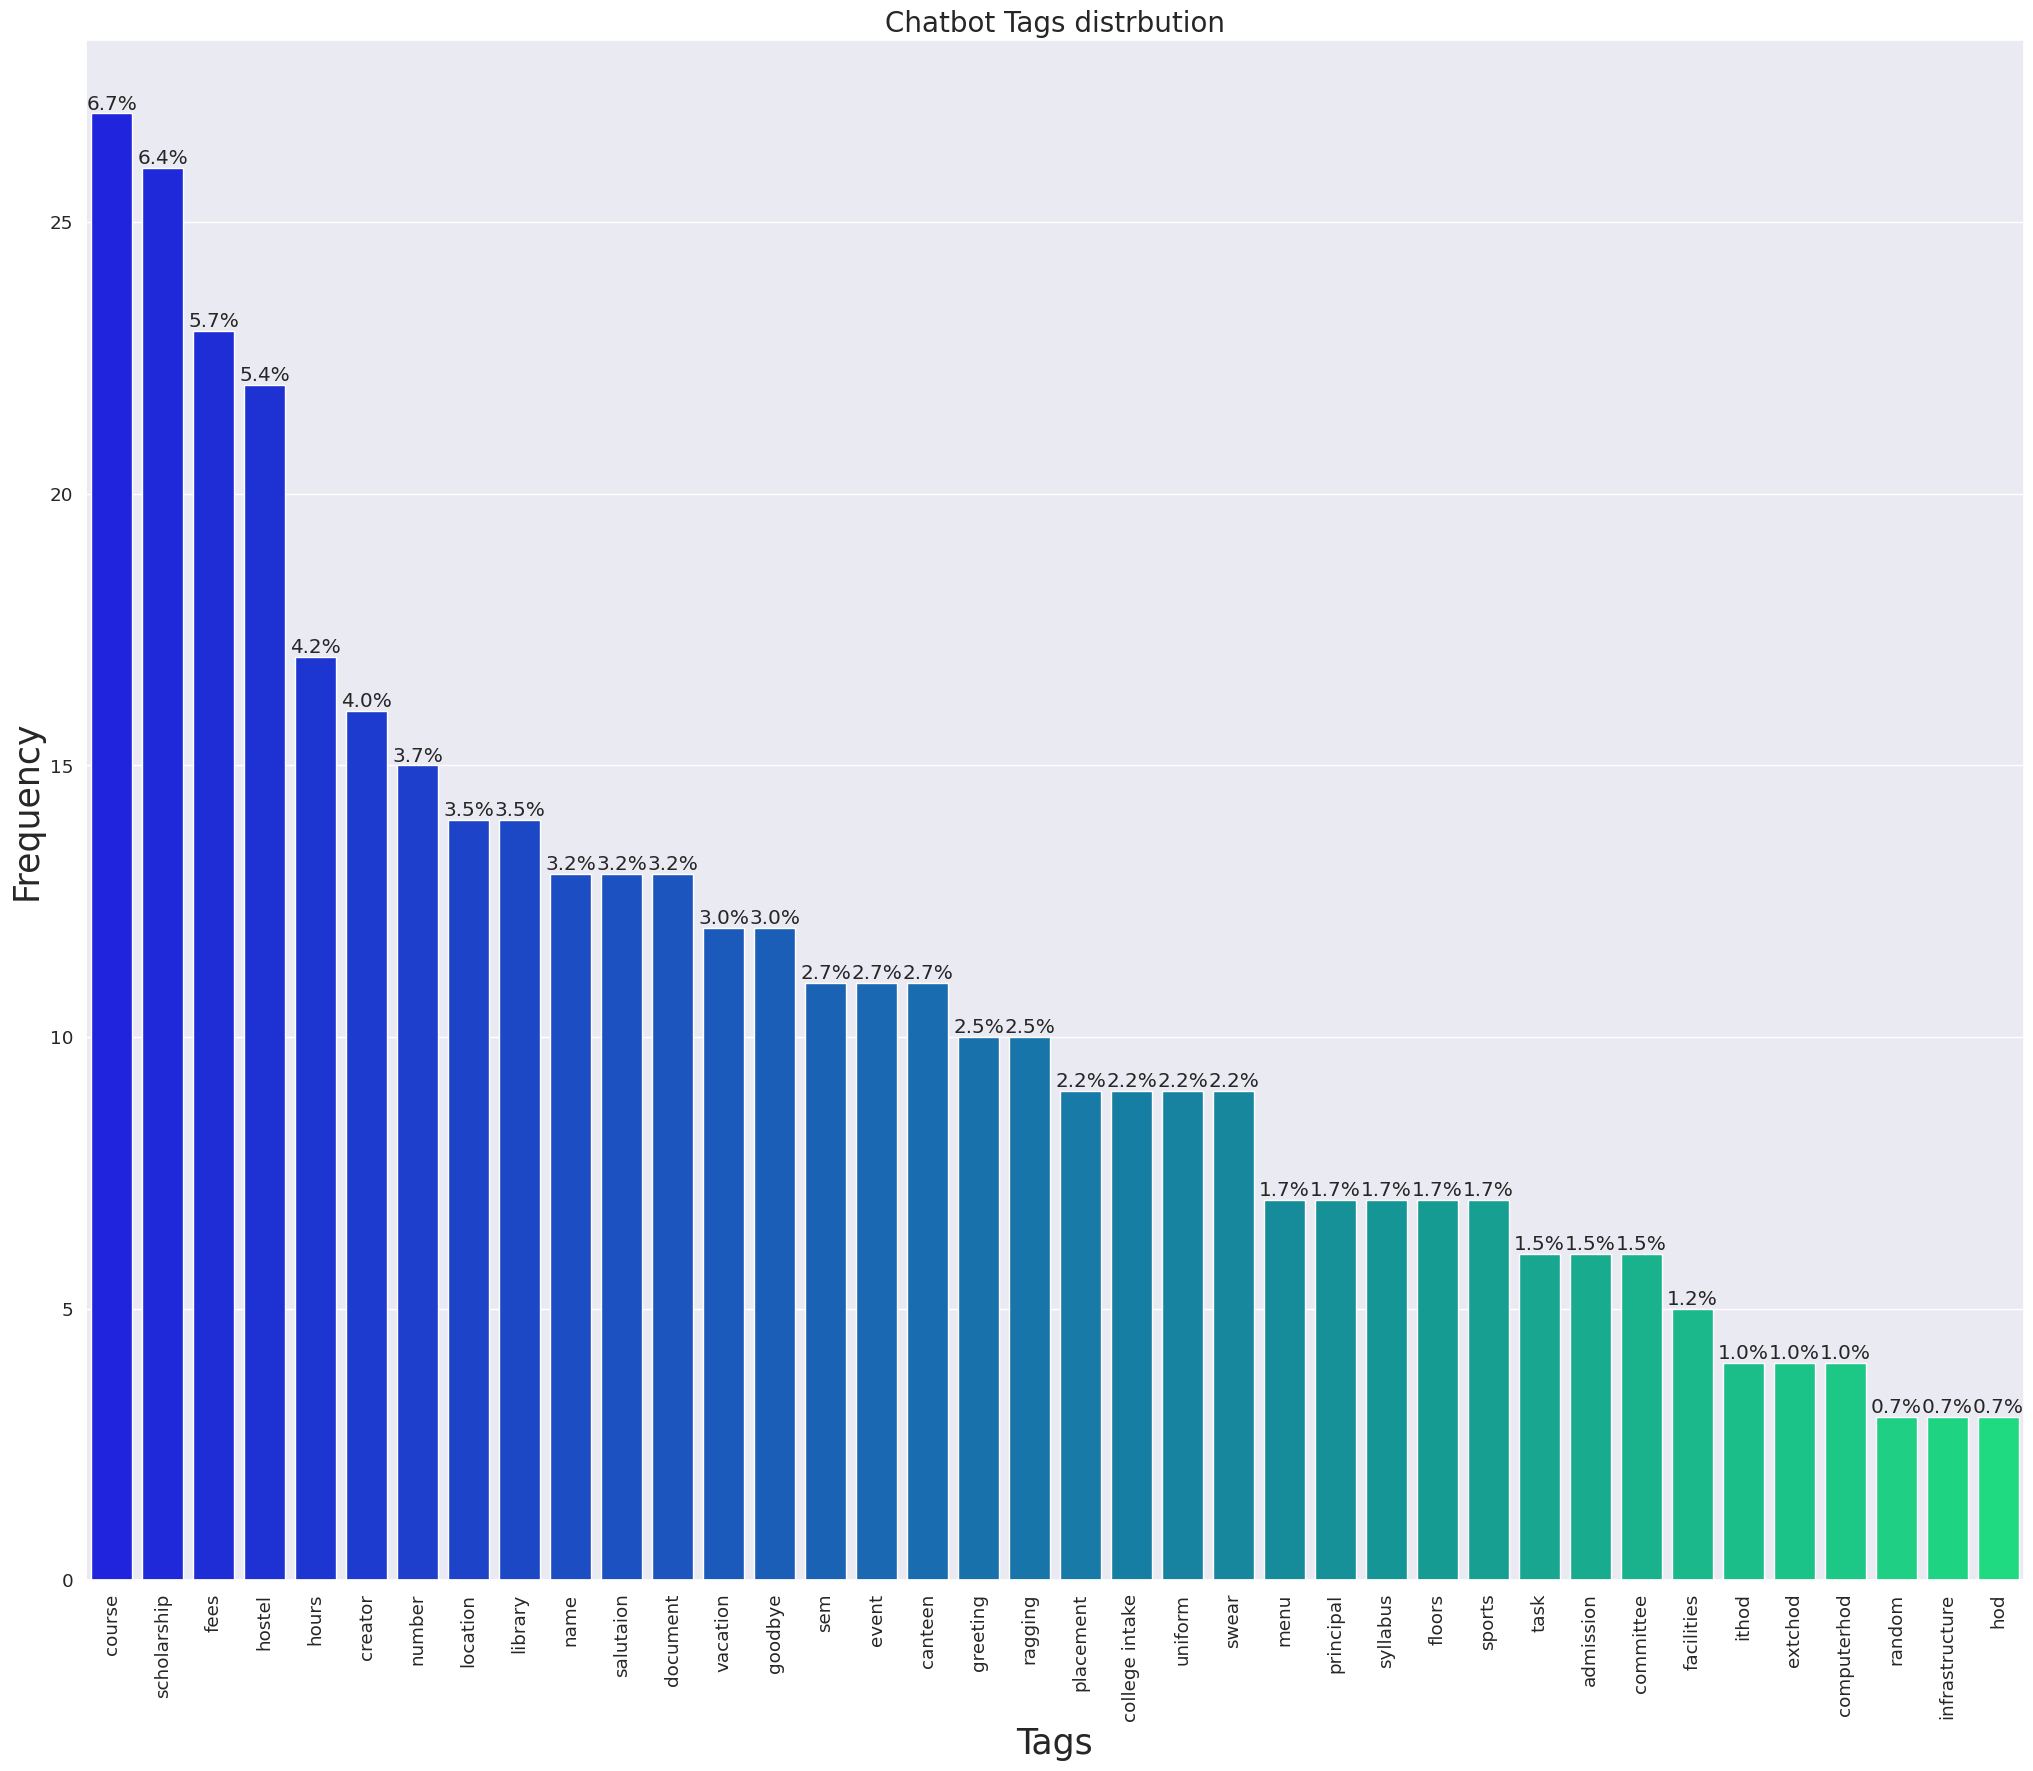

In [ ]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 25,20,order=order,rotation=True, palette="winter")

In [ ]:
import nltk
nltk.download('punkt')
stemmer = PorterStemmer()
ignore_words = ['?', '!', ',', '.']
df['Pattern'] = df['Pattern'].apply(lambda pattern: ' '.join([stemmer.stem(word) for word in word_tokenize(pattern.lower()) if word not in ignore_words]))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [ ]:
print(df['Pattern'].isnull().sum())

0


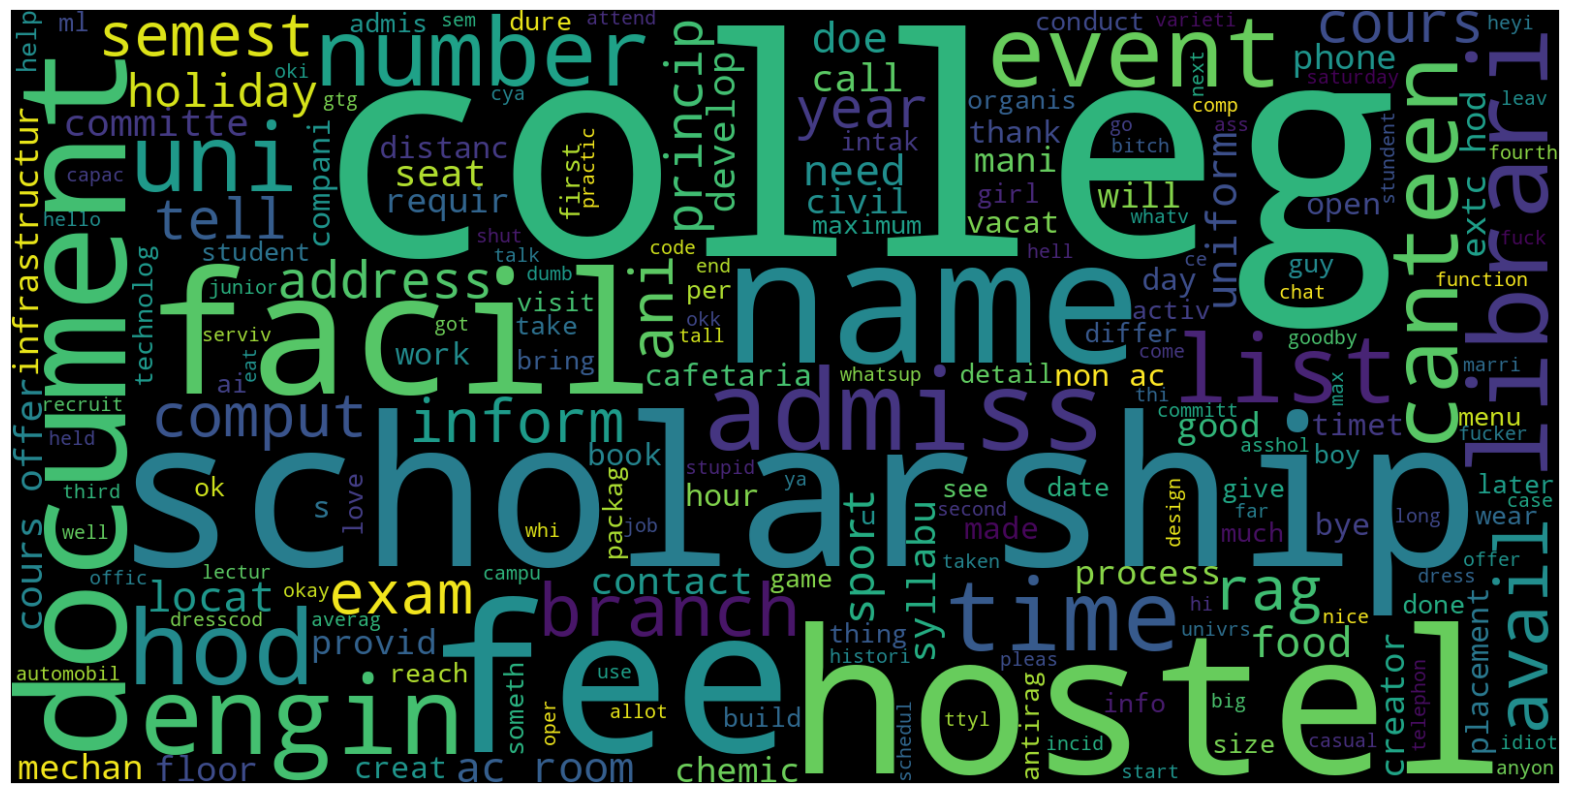

In [ ]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

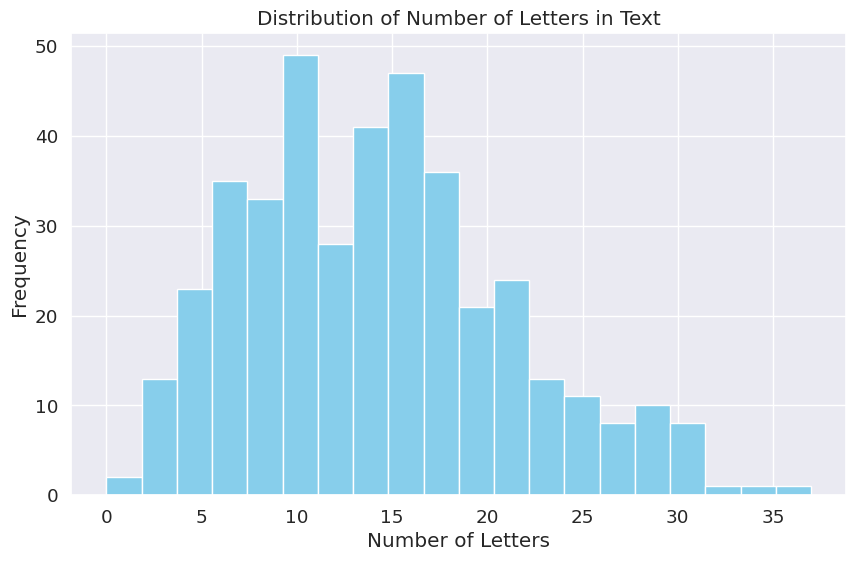

In [ ]:
Number_of_letters = df['Pattern'].apply(lambda x: len([c for c in x if c.isalpha()]))

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(Number_of_letters, bins=20, color='skyblue')
plt.title('Distribution of Number of Letters in Text')
plt.xlabel('Number of Letters')
plt.ylabel('Frequency')
plt.show()

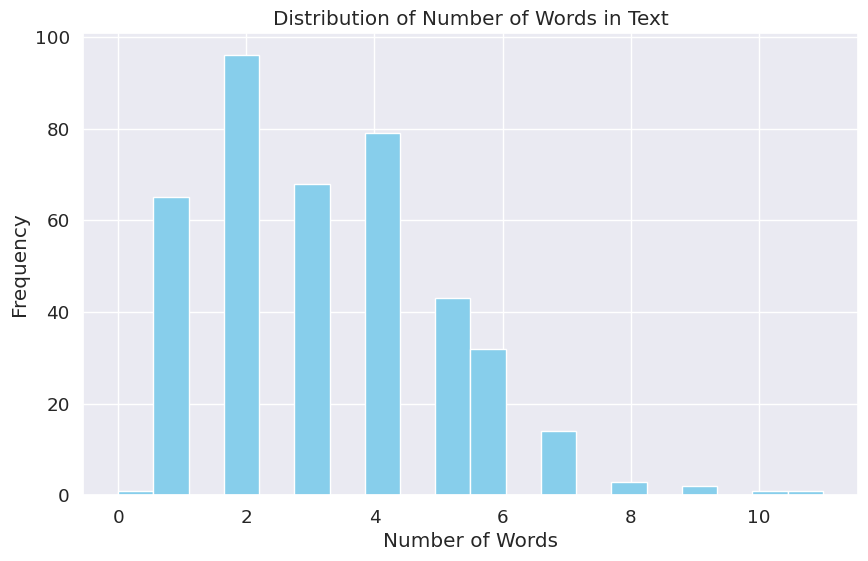

In [ ]:
Number_of_words = df['Pattern'].apply(lambda x: len(x.split()))

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(Number_of_words, bins=20, color='skyblue')
plt.title('Distribution of Number of Words in Text')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB


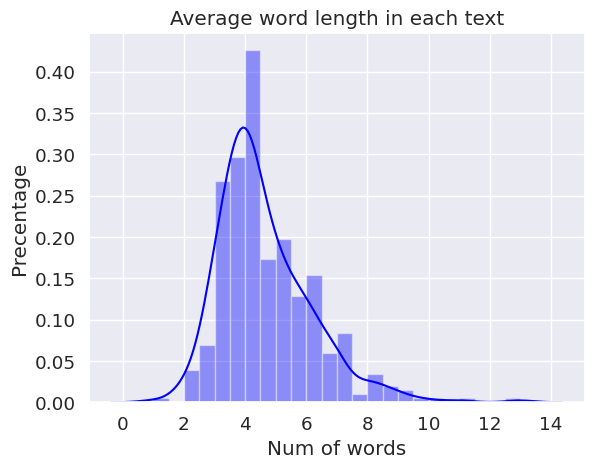

In [ ]:
average = df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
average = average.map(lambda x: np.mean(x))
sns.distplot(average,color='blue')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [ ]:
all_text = ' '.join(df['Pattern'])

# Tokenize the concatenated string to count the words
word_count = len(word_tokenize(all_text))

print(f'Total number of words in the dataset: {word_count}')

Total number of words in the dataset: 1345


In [ ]:
from collections import Counter

all_words = word_tokenize(' '.join(df['Pattern']))

# Count the occurrences of each word
word_counts = Counter(all_words)

# Get the most common words (e.g., top 10)
most_common_words = word_counts.most_common(10)

# Print the most common words and their counts
for word, count in most_common_words:
    print(f'{word}: {count}')

is: 75
colleg: 71
what: 59
the: 46
you: 35
of: 33
in: 29
for: 26
scholarship: 26
are: 25


In [ ]:
df2 = df.copy()

In [ ]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [ ]:
num_labels = len(labels)
id_then_label = {id:label for id, label in enumerate(labels)}
label_then_id = {label:id for id, label in enumerate(labels)}

In [ ]:
df2['labels'] = df2['Tag'].map(lambda x: label_then_id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,hi,greeting,0
1,how are you,greeting,0
2,is anyon there,greeting,0
3,hello,greeting,0
4,good day,greeting,0


In [ ]:
X = list(df2['Pattern'])
X[:5]

y = list(df2['labels'])
y[:5]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [ ]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id_then_label,
                                                      label2id = label_then_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
from accelerate import Accelerator
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.538800,3.400648,0.127451,0.046063,0.033740,0.091398
100,2.706300,2.284724,0.588235,0.461292,0.498754,0.507812
150,1.314600,1.042740,0.901961,0.845044,0.872222,0.841414
200,0.427300,0.522048,0.911765,0.889570,0.905729,0.902083
250,0.128900,0.390639,0.941176,0.939606,0.947312,0.953763
300,0.072100,0.416906,0.931373,0.932065,0.939247,0.948387
350,0.043800,0.407668,0.921569,0.898598,0.908333,0.910937
400,0.033400,0.423614,0.921569,0.898598,0.908333,0.910937
450,0.027600,0.409996,0.921569,0.898598,0.908333,0.910937
500,0.021100,0.414675,0.921569,0.898598,0.908333,0.910937


TrainOutput(global_step=1000, training_loss=0.42331579756736754, metrics={'train_runtime': 6407.4966, 'train_samples_per_second': 4.729, 'train_steps_per_second': 0.156, 'total_flos': 264789670748400.0, 'train_loss': 0.42331579756736754, 'epoch': 100.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.015005,0.996700,0.998528,0.998452,0.998684
test,0.414675,0.921569,0.898598,0.908333,0.910937


In [ ]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cpu")
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]
    return probs, pred_label_idx, pred_label

In [ ]:
text = "Hello"
predict(text)

(tensor([[9.8781e-01, 3.4674e-04, 1.0455e-04, 7.3599e-04, 8.4602e-04, 3.3258e-04,
          1.4458e-04, 1.5801e-04, 2.9512e-04, 3.1949e-04, 2.2062e-04, 8.9201e-04,
          1.2725e-04, 4.1327e-04, 5.1779e-04, 2.6340e-04, 3.4475e-05, 4.3544e-05,
          4.7925e-05, 1.5878e-04, 1.0449e-04, 4.0194e-04, 8.8750e-05, 3.5013e-04,
          1.4692e-04, 6.1094e-04, 2.9111e-04, 1.9182e-04, 4.2404e-04, 1.6057e-04,
          1.2692e-04, 6.4934e-05, 6.8162e-04, 7.2704e-04, 4.7143e-04, 2.6142e-04,
          3.9106e-04, 6.9326e-04]], grad_fn=<SoftmaxBackward0>),
 tensor(0),
 'greeting')

In [ ]:
text2 = "is anyone here"
predict(text2)

(tensor([[8.8188e-01, 4.8683e-04, 1.1788e-03, 5.2167e-02, 4.8022e-03, 7.1952e-03,
          3.3101e-04, 6.4716e-04, 1.3018e-03, 1.1056e-03, 1.8444e-03, 3.4197e-03,
          9.7971e-04, 1.2364e-03, 1.9430e-03, 7.4674e-04, 3.2787e-04, 2.6047e-04,
          6.9749e-04, 1.3608e-03, 4.5720e-04, 1.8853e-03, 5.7368e-04, 1.0207e-03,
          7.0694e-04, 1.8117e-03, 8.0395e-04, 9.7899e-04, 2.2629e-03, 6.6351e-04,
          7.2799e-04, 4.7425e-04, 2.6384e-03, 3.8037e-03, 1.0666e-03, 2.9124e-03,
          1.3101e-03, 1.1989e-02]], grad_fn=<SoftmaxBackward0>),
 tensor(0),
 'greeting')

In [ ]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [ ]:
!pip install xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
model_path = "/content/chatbot"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9878095388412476}]

In [ ]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label_then_id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()

In [ ]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User: good morning
Chatbot: Hello!


User: hello
Chatbot: Hi there, how can I help?


User: what's your name
Chatbot: I am a Chatbot.


User: who created you
Chatbot: College students


User: what should i call you
Chatbot: I'm Mind Reader


User: when are you guys open
Chatbot: College is open 8am-5pm Monday-Saturday!


User: contact number?
Chatbot: You can contact at: NUMBER


User: branches available at your college?
Chatbot: Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering.


User: IT
Chatbot: Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering.


User: tell me the fee
Chatbot: For Fee detail visit <a target="_blank" href="LINK"